In [1]:
from bs4 import BeautifulSoup
import re,string,unicodedata
from string import punctuation

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from sklearn.preprocessing import LabelBinarizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize
from keras.preprocessing import text, sequence


import keras
from keras.models import Sequential
from keras.layers import Dense,Embedding,LSTM,Dropout,Bidirectional,GRU
import tensorflow as tf


from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
df = pd.read_csv("data/NEWS_YAHOO_stock_prediction.csv")
df.head(10)

,Unnamed: 0,ticker,Date,category,title,content,Open,High,Low,Close,Adj Close,Volume,label
0,0,AAPL,2020-01-27,opinion,Apple Set To Beat Q1 Earnings Estimates Tech ...,Technology giant Apple NASDAQ AAPL is set ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
1,1,AAPL,2020-01-27,opinion,Tech Daily Intel Results Netflix Surge Appl...,The top stories in this digest are Intel s N...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
2,2,AAPL,2020-01-27,opinion,7 Monster Stock Market Predictions For The Wee...,S P 500 SPY \nThis week will be packed with e...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
3,3,AAPL,2020-01-27,opinion,Apple Earnings Preview 5G Launch Expanding S...,Reports Q1 2020 results on Tuesday Jan 28 ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
4,4,AAPL,2020-01-27,opinion,Buy Surging Apple Microsoft Stock Before Qua...,On today s episode of Full Court Finance here ...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
5,5,AAPL,2020-01-27,opinion,Top Stock Analyst Reports For Merck Broadcom ...,Monday January 27 2020The Zacks Research Dai...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
6,6,AAPL,2020-01-27,news,Stocks Europe Seen Opening Lower as Virus Co...,By Peter Nurse \nInvesting com European stoc...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
7,7,AAPL,2020-01-27,news,Intelligent Systems wins bullish rating from B...,BTIG analyst Mark Palmer initiates coverage of...,77.514999,77.942497,76.220001,77.237503,75.793358,161940000,0
8,8,AAPL,2020-01-24,opinion,What To Do If A Stock On Your Buy List Has A...,I got a great question recently from Barbara P...,80.062500,80.832497,79.379997,79.577499,78.089607,146537600,0
9,9,AAPL,2020-01-24,opinion,Previewing Tech Sector Earnings,We get into the heart of the Q4 earnings seaso...,80.062500,80.832497,79.379997,79.577499,78.089607,146537600,0


In [3]:
df = df[["title", "label"]]

In [4]:
df.shape

(15975, 2)

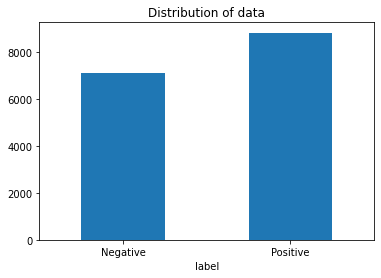

In [5]:
ax = df.groupby('label').count().plot(kind='bar', title='Distribution of data',
                                               legend=False)
ax = ax.set_xticklabels(['Negative','Positive'], rotation=0)

In [6]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [7]:
def decontracted(phrase):
    if "'" in phrase:
        # specific
        phrase = re.sub(r"won't", "will not", phrase)
        phrase = re.sub(r"can\'t", "can not", phrase)

        # general
        phrase = re.sub(r"n\'t", " not", phrase)
        phrase = re.sub(r"\'re", " are", phrase)
        phrase = re.sub(r"\'s", " is", phrase)
        phrase = re.sub(r"\'d", " would", phrase)
        phrase = re.sub(r"\'ll", " will", phrase)
        phrase = re.sub(r"\'t", " not", phrase)
        phrase = re.sub(r"\'ve", " have", phrase)
        phrase = re.sub(r"\'m", " am", phrase)
    return phrase
def clean_text(text):
    '''Remove unwanted characters and format the text to create fewer nulls word embeddings'''
    
    # convert words into lower case
    text= text.lower()
    
    # Replace contraction with their longest forms
    if True:
        text = text.split()
        new_text = []
        # Remove the contractions
        for word in text:
            new_text.append(decontracted(word))
        # Recreate the sentence
        text= ' '.join(new_text)
        
    # Format words and remove unwanted characters
    text = re.sub(r'&amp;','', text)
    text= re.sub(r'0,0','00', text)
    text = re.sub(r'[_"\-;%()|.,+&=*%.,!?:#@\[\]]', ' ', text)
    text = re.sub(r'\'', ' ', text)
    text = re.sub(r'\$', ' $ ', text)
    text = re.sub(r'u s ', ' united states ', text)
    text = re.sub(r'u n ', ' united nations ', text)
    text = re.sub(r'u k ', ' united kingdom ', text)
    text = re.sub(r'j k ', ' jk ', text)
    text = re.sub(r' s ', ' ', text)
    text = re.sub(r' yr ', ' year ', text)
    text = re.sub(r' l g b t ', ' lgbt ', text)
    text = re.sub(r'0km ', '0 km ', text)
    
    # Remove stopwords
    text=text.split()
    stops= set(stopwords.words('english'))
    text = [w for w in text if w not in stops]
    text= " ".join(text)
    
    return text
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]#', '', text)
def remove_links(text):
    return re.sub(r'http\S+', '', text)
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)
def cleanse_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_links(text)
    text = remove_stopwords(text)
    text = clean_text(text)
    return text

In [8]:
%time
df['title']=df['title'].apply(cleanse_text)

CPU times: total: 0 ns
Wall time: 0 ns


In [9]:
df['title']

0        apple set beat q1 earnings estimates tech etfs...
1        tech daily intel results netflix surge apple v...
2        7 monster stock market predictions week januar...
3        apple earnings preview 5g launch expanding ser...
4        buy surging apple microsoft stock quarterly ea...
                               ...                        
15970               driving china real estate rally part 3
15971             50 stocks best dividend growth july 2012
15972                        summer heat scorches europe u
15973            apple earnings preview quarterly dip deck
15974                                 trade apple earnings
Name: title, Length: 15975, dtype: object

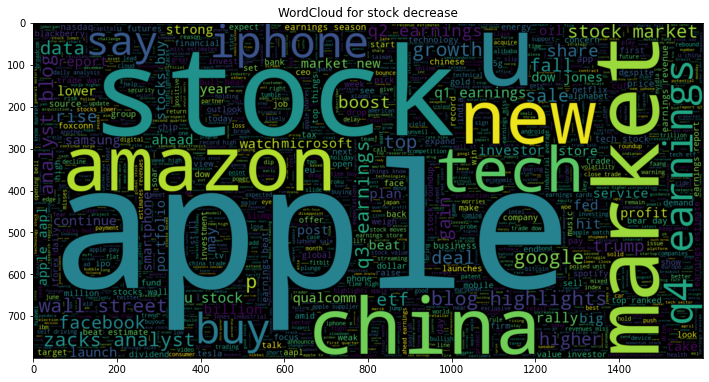

In [11]:
plt.figure(figsize = (12,10)) 
plt.title("WordCloud for stock decrease")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 0].title))
plt.imshow(wc , interpolation = 'bilinear')

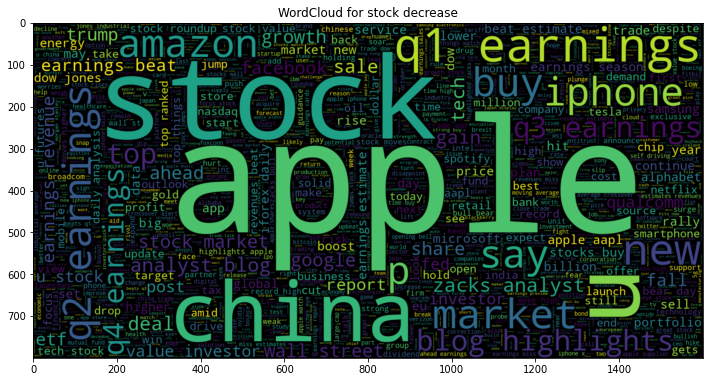

In [12]:
plt.figure(figsize = (12,10)) 
plt.title("WordCloud for stock decrease")
wc = WordCloud(max_words = 2000 , width = 1600 , height = 800).generate(" ".join(df[df.label == 1].title))
plt.imshow(wc , interpolation = 'bilinear')

In [13]:
words = []
for i in df.title.values:
    words.append(i.split())
words[:5]

[['apple',
  'set',
  'beat',
  'q1',
  'earnings',
  'estimates',
  'tech',
  'etfs',
  'buy'],
 ['tech',
  'daily',
  'intel',
  'results',
  'netflix',
  'surge',
  'apple',
  'valuation',
  'google',
  'atvi',
  'deal'],
 ['7', 'monster', 'stock', 'market', 'predictions', 'week', 'january', '27'],
 ['apple',
  'earnings',
  'preview',
  '5g',
  'launch',
  'expanding',
  'services',
  'business',
  'fuel',
  'growth'],
 ['buy', 'surging', 'apple', 'microsoft', 'stock', 'quarterly', 'earnings']]

In [14]:
import gensim
EMBEDDING_DIM = 200

In [15]:
%time
w2v_model = gensim.models.Word2Vec(sentences = words , vector_size=EMBEDDING_DIM , window = 5 , min_count = 1)

CPU times: total: 0 ns
Wall time: 0 ns


In [16]:
len(w2v_model.wv.index_to_key)

13017

In [17]:
from keras.utils import pad_sequences

In [18]:
tokenizer = text.Tokenizer(num_words=20000)
tokenizer.fit_on_texts(words)
tokenized_train = tokenizer.texts_to_sequences(words)
x = pad_sequences(tokenized_train, maxlen = 100)

In [19]:
x

array([[    0,     0,     0, ...,     7,    60,    10],
       [    0,     0,     0, ...,    46,  2224,    50],
       [    0,     0,     0, ...,    38,   610,   526],
       ...,
       [    0,     0,     0, ..., 13017,   305,     5],
       [    0,     0,     0, ...,   698,   540,  1521],
       [    0,     0,     0, ...,    15,     1,     2]])

In [20]:
x.shape

(15975, 100)

In [21]:
vocab_size = len(tokenizer.word_index) + 1

In [22]:
def get_weight_matrix(model, vocab):
    # total vocabulary size plus 0 for unknown words
    vocab_size = len(vocab) + 1
    # defining the weight matrix dimensions with all 0
    weight_matrix = np.zeros((vocab_size, EMBEDDING_DIM))
    # step vocab, store vectors using the Tokenizer's integer mapping
    for word, i in vocab.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [23]:
embedding_vectors = get_weight_matrix(w2v_model, tokenizer.word_index)

In [24]:
embedding_vectors.shape

(13018, 200)

In [25]:
#Defining Neural Network
model = Sequential()
#Non-trainable embeddidng layer
model.add(Embedding(vocab_size, output_dim=EMBEDDING_DIM, weights=[embedding_vectors], input_length=100, trainable=True))
#LSTM 
model.add(Bidirectional(LSTM(units=128 , recurrent_dropout = 0.3 , dropout = 0.3,return_sequences = True)))
model.add(Bidirectional(GRU(units=32 , recurrent_dropout = 0.1 , dropout = 0.1)))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=keras.optimizers.Adam(lr = 0.001), loss='binary_crossentropy', metrics=['accuracy'])

del embedding_vectors

c:\Users\84866\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, df.label , test_size = 0.3 , random_state = 0, shuffle=False) 

In [29]:
history = model.fit(x_train, y_train, batch_size = 124 , validation_data = (x_test,y_test) , epochs = 10)

Epoch 1/10


91/91 [==============================] - 483s 5s/step - loss: 0.6872 - accuracy: 0.5556 - val_loss: 0.6929 - val_accuracy: 0.5450
Epoch 2/10
91/91 [==============================] - 535s 6s/step - loss: 0.6770 - accuracy: 0.5770 - val_loss: 0.6948 - val_accuracy: 0.5372
Epoch 3/10
91/91 [==============================] - 594s 7s/step - loss: 0.5385 - accuracy: 0.7260 - val_loss: 0.7966 - val_accuracy: 0.5208
Epoch 4/10
91/91 [==============================] - 600s 7s/step - loss: 0.3437 - accuracy: 0.8444 - val_loss: 0.9941 - val_accuracy: 0.5224
Epoch 5/10
91/91 [==============================] - 898s 10s/step - loss: 0.2499 - accuracy: 0.8883 - val_loss: 1.1559 - val_accuracy: 0.5118
Epoch 6/10
91/91 [==============================] - 607s 7s/step - loss: 0.1974 - accuracy: 0.9127 - val_loss: 1.3779 - val_accuracy: 0.5110
Epoch 7/10
44/91 [=============>................] - ETA: 5:54 - loss: 0.1543 - accuracy: 0.9362

KeyboardInterrupt: 

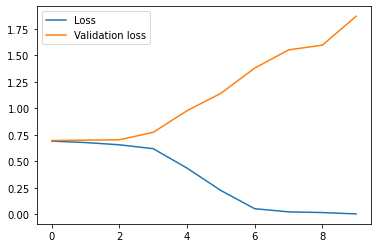

In [ ]:
plt.plot(history.history["loss"], label="Loss")
plt.plot(history.history["val_loss"], label="Validation loss")
plt.legend()
plt.show()

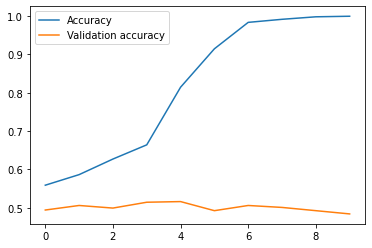

In [ ]:
plt.plot(history.history["accuracy"], label="Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation accuracy")
plt.legend()
plt.show()